# Montando o Google Drive

In [ ]:
#conecta com o google drive
from google.colab import drive
drive.mount('/content/drive', timeout_ms=10200000)


Mounted at /content/drive


# Importando Bibliotecas

In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms, datasets, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torch.utils.data import DataLoader

import seaborn as sns

# Configurações para reprodutibildade

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# O Dataset

In [ ]:
ds_path = '/content/drive/MyDrive/Projetos/Projeto2Visao/dataset'

In [ ]:
# Número de classes
num_classes = 11

# Nomes das classes
class_names = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightining', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']

# Tamanho do lote (mini-batch)
batch_size = 64

# Taxa de aprendizado
lr = 0.001

# Número de épocas
epochs = 50
### epochs = 50

In [ ]:
# Treinamento
data_transforms = transforms.Compose([

    #Estratégias de Data Augmentation (rotação e flips)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),

    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(ds_path, transform=data_transforms)

In [ ]:
# Porcentagens para os conjuntos
train_percent = 0.7  # 70% para treino
val_percent = 0.2    # 20% para validação
test_percent = 0.1   # 10% para teste

# Tamanhos dos conjuntos
train_size = int(train_percent * len(full_dataset))
val_size = int(val_percent * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Dividindo o dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Número de imagens em cada dataset
print("Tamanhos dos conjuntos:")
print(f"Treino: {len(train_dataset)}")
print(f"Validação: {len(val_dataset)}")
print(f"Teste: {len(test_dataset)}")

# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)


Tamanhos dos conjuntos:
Treino: 4803
Validação: 1372
Teste: 687


In [ ]:
# Definindo as classes do dataset
classes = train_dataset.dataset.classes

In [ ]:
print(classes)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


#Seleção do Modelo

In [ ]:
# Carregando o modelo Pré-Treinado
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Altera o número de neurônios na cadama de saída.
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

print(str(model))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Verificação de Acesso à GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

Using device: cuda


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
!nvidia-smi


Sun Jan 12 03:50:55 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              28W /  70W |    137MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Definição da função de perda e do otimizador

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.Adam(model.parameters(), lr=lr)

#Treinando o Modelo

Treinamento - epoca 0
Validacao - epoca 0
Epoch 0/49 - TRAIN Loss: 0.6331 TRAIN Acc: 0.8041 - VAL. Loss: 0.3756 VAL. Acc: 0.8812 (4541.3395 seconds)
Treinamento - epoca 1
Validacao - epoca 1
Epoch 1/49 - TRAIN Loss: 0.3384 TRAIN Acc: 0.8899 - VAL. Loss: 0.3663 VAL. Acc: 0.8790 (93.1178 seconds)
Treinamento - epoca 2
Validacao - epoca 2
Epoch 2/49 - TRAIN Loss: 0.2608 TRAIN Acc: 0.9157 - VAL. Loss: 0.3324 VAL. Acc: 0.9001 (93.1464 seconds)
Treinamento - epoca 3
Validacao - epoca 3
Epoch 3/49 - TRAIN Loss: 0.2456 TRAIN Acc: 0.9194 - VAL. Loss: 0.4116 VAL. Acc: 0.8958 (93.6653 seconds)
Treinamento - epoca 4
Validacao - epoca 4
Epoch 4/49 - TRAIN Loss: 0.1922 TRAIN Acc: 0.9357 - VAL. Loss: 0.3014 VAL. Acc: 0.9052 (94.0922 seconds)
Treinamento - epoca 5
Validacao - epoca 5
Epoch 5/49 - TRAIN Loss: 0.1326 TRAIN Acc: 0.9538 - VAL. Loss: 0.3599 VAL. Acc: 0.9082 (93.8060 seconds)
Treinamento - epoca 6
Validacao - epoca 6
Epoch 6/49 - TRAIN Loss: 0.1241 TRAIN Acc: 0.9582 - VAL. Loss: 0.4244 VAL.

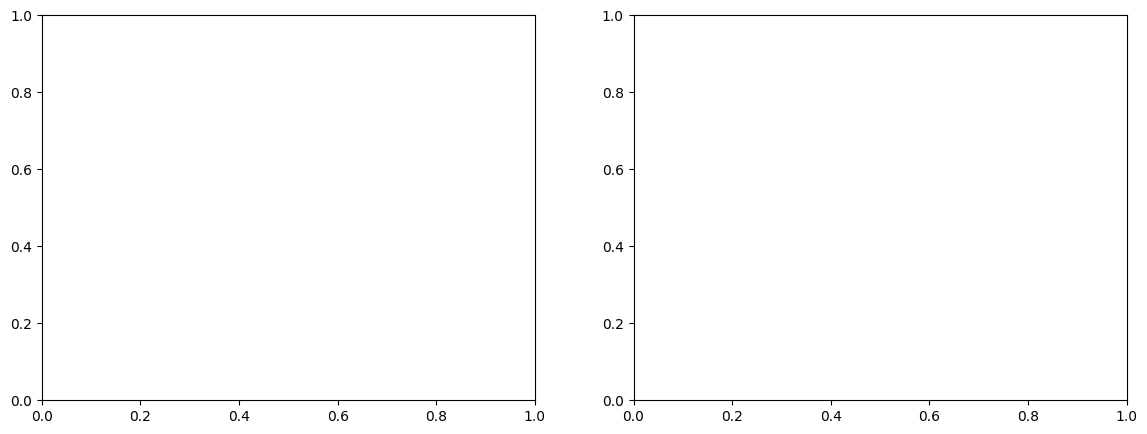

In [ ]:
"""
#para retomar o  treinamento do último checkpoint salvo (em caso de queda do ambiente de execução)

# Carregar o checkpoint completo
checkpoint = torch.load('checkpoint.pth')

# Reconstruir o modelo e otimizador
model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# Restaurar os estados
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # Para continuar do próximo
loss = checkpoint['loss']  # Opcional: carregar última perda

# Agora você pode continuar treinando
"""

# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de treino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

# Melhor acurácia de validação
best_val_acc = 0.0

# Inicializa a figura para o acompanhamento visual
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for epoch in range(epochs):
    print(f"Treinamento - epoca {epoch}")
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    num_hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita o cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model(inputs)

        # 'outputs' está em porcentagens. Tomar os máximos como resposta.
        preds = torch.argmax(outputs, dim=1)

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += loss.item() * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        num_hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = num_hits_epoch_train.double() / train_size

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc.cpu().item())  # Move para CPU e converte para float

    # VALIDAÇÃO
    # =========================================================================
    model.eval()
    print(f"Validacao - epoca {epoch}")

    # Pego o número de perda e o número de acertos
    loss_epoch_val = 0.0 # Atual perda
    num_hits_epoch_val = 0 # Número de itens corretos

    # Iterate along the batches of the VALIDATION SET
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Gero um tensor cujas linhas representam o tamanho do "batch" do input
            outputs = model(inputs)

            # Retorna a maior predição.
            preds = torch.argmax(outputs, dim=1)

            # Calcula a perda (loss)
            loss = criterion(outputs, labels)

            # Atualiza a perda da época
            loss_epoch_val += loss.item() * inputs.size(0)
            # Atualiza os acertos da época
            num_hits_epoch_val += torch.sum(preds == labels.data)

    # Perda e acurácia do conjunto de validação para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = num_hits_epoch_val.double() / val_size

    # Store loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc.cpu().item())  # Move para CPU e converte para float

    # Salvar o melhor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, '/content/drive/MyDrive/Projetos/Projeto2Visao/Testes/EfficientNet/50epocas/checkpoint.pth')

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print('Epoch {}/{} - TRAIN Loss: {:.4f} TRAIN Acc: {:.4f} - VAL. Loss: {:.4f} VAL. Acc: {:.4f} ({:.4f} seconds)'.format(epoch, epochs - 1, train_loss, train_acc, val_loss, val_acc, time_epoch))


# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print('\nTreinamento finalizado. ({0}m and {1}s)'.format(int(time_total_train // 60), int(time_total_train % 60)))

#Analisando o Treinamento

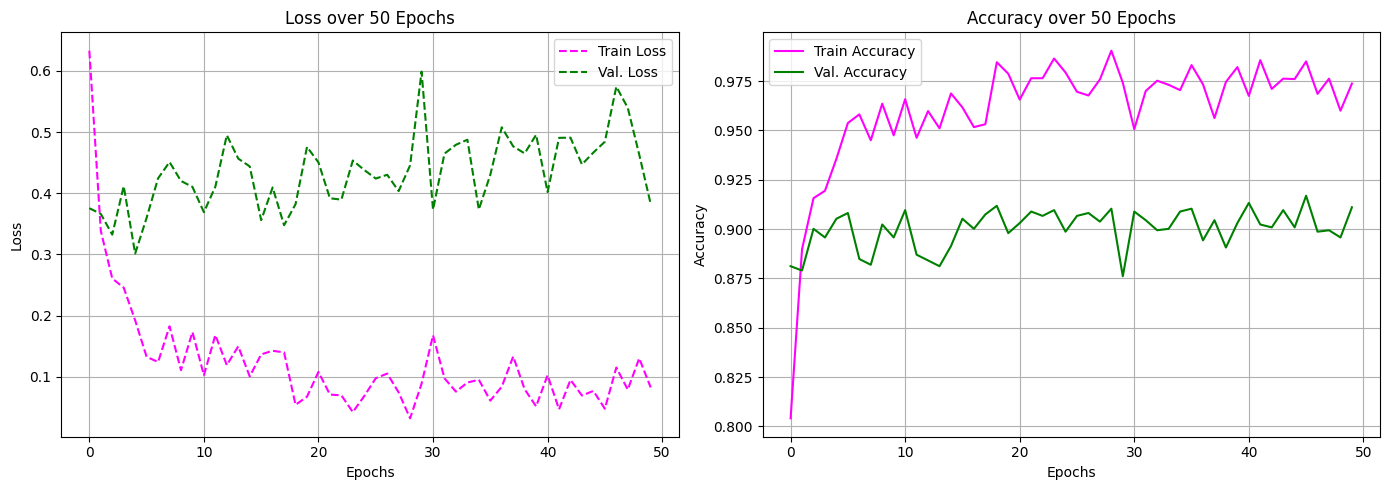

In [ ]:
# Lista com os índices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_loss_list)))

# Títulos
loss_title = f'Loss over {len(epochs_list)} Epochs'
acc_title = f'Accuracy over {len(epochs_list)} Epochs'

# Plot - Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot - Loss
ax1.set_title(loss_title)
ax1.plot(epochs_list, train_loss_list, c='magenta', ls='--', label='Train Loss', fillstyle='none')
ax1.plot(epochs_list, val_loss_list, c='green', ls='--', label='Val. Loss', fillstyle='none')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')
ax1.grid(True)

# Plot - Accuracy
ax2.set_title(acc_title)
ax2.plot(epochs_list, train_acc_list, c='magenta', ls='-', label='Train Accuracy', fillstyle='none')
ax2.plot(epochs_list, val_acc_list, c='green', ls='-', label='Val. Accuracy', fillstyle='none')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Avaliando o Modelo

In [ ]:
# Carregando o modelo Pré-Treinado
model = models.efficientnet_b0(weights=None)

# Altera o número de neurônios na cadama de saída.
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

# Carregar o melhor modelo salvo
checkpoint = torch.load('/content/drive/MyDrive/Projetos/Projeto2Visao/Testes/EfficientNet/50epocas/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']

print(f"Melhor Época {start_epoch}")


model.eval()

# Lista com as classes reais e classes preditas
true_test_list = []
pred_test_list = []
# Lista com as probabilidades
prob_test_list = []

# Iterate along the batches of the TEST SET
with torch.no_grad():
    for img_list, labelList in test_dataloader:
        img_list, labelList = img_list.to(device), labelList.to(device)

        # -----> FORWARD
        # Saída do modelo
        outputs = model(img_list)

        # Predição
        preds = torch.argmax(outputs, dim=1)

        # Calcula probabilidades
        outputs_prob = nn.functional.softmax(outputs, dim=1)
        prob_test_batch = outputs_prob.cpu().numpy()

        # Classes reais (true) e classes preditas (pred) para este lote.
        true_test_batch = labelList.cpu().numpy()
        pred_test_batch = preds.cpu().numpy()

        # Adiciona os resultados às listas
        true_test_list.extend(true_test_batch)
        pred_test_list.extend(pred_test_batch)
        prob_test_list.extend(prob_test_batch)

Using device: cuda


<ipython-input-16-a9c57133efdc>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Projetos/Projeto2Visao/Testes/EfficientNet/

Melhor Época 45


# Matrix de Confusão e Relatório de Classificação

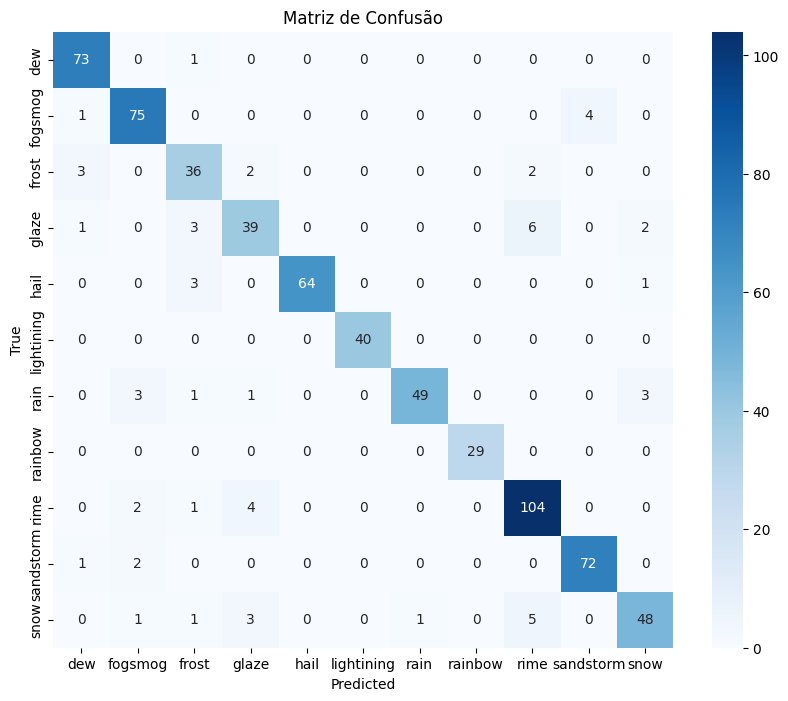


Class. report (test)
{'dew': {'precision': 0.9240506329113924, 'recall': 0.9864864864864865, 'f1-score': 0.954248366013072, 'support': 74.0}, 'fogsmog': {'precision': 0.9036144578313253, 'recall': 0.9375, 'f1-score': 0.9202453987730062, 'support': 80.0}, 'frost': {'precision': 0.782608695652174, 'recall': 0.8372093023255814, 'f1-score': 0.8089887640449438, 'support': 43.0}, 'glaze': {'precision': 0.7959183673469388, 'recall': 0.7647058823529411, 'f1-score': 0.78, 'support': 51.0}, 'hail': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 68.0}, 'lightining': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 40.0}, 'rain': {'precision': 0.98, 'recall': 0.8596491228070176, 'f1-score': 0.9158878504672897, 'support': 57.0}, 'rainbow': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 29.0}, 'rime': {'precision': 0.8888888888888888, 'recall': 0.9369369369369369, 'f1-score': 0.9122807017543859, 'support': 111.0}, 'sandstorm':

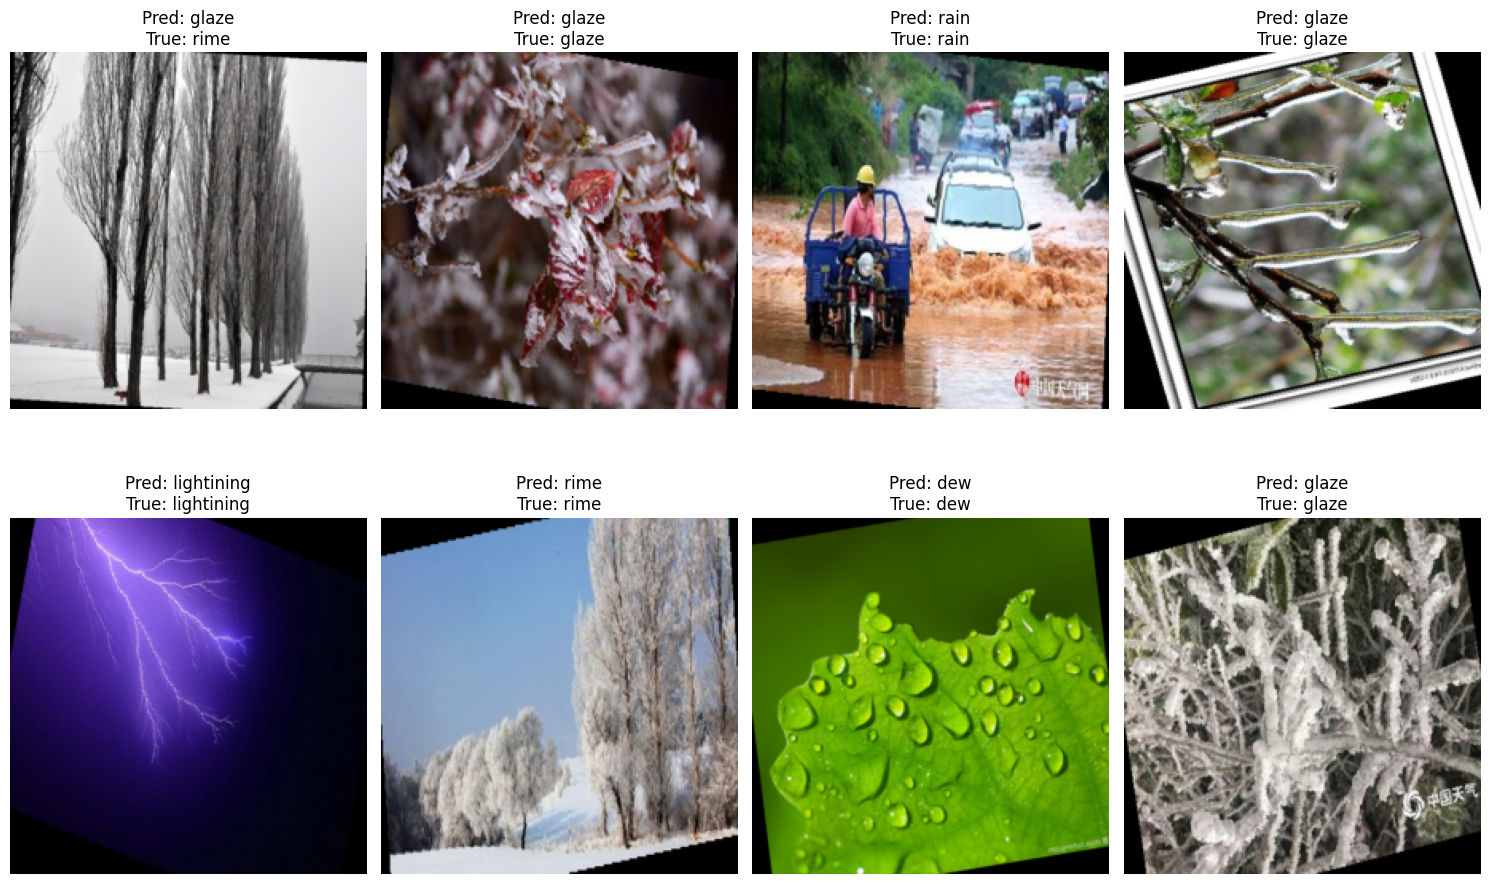

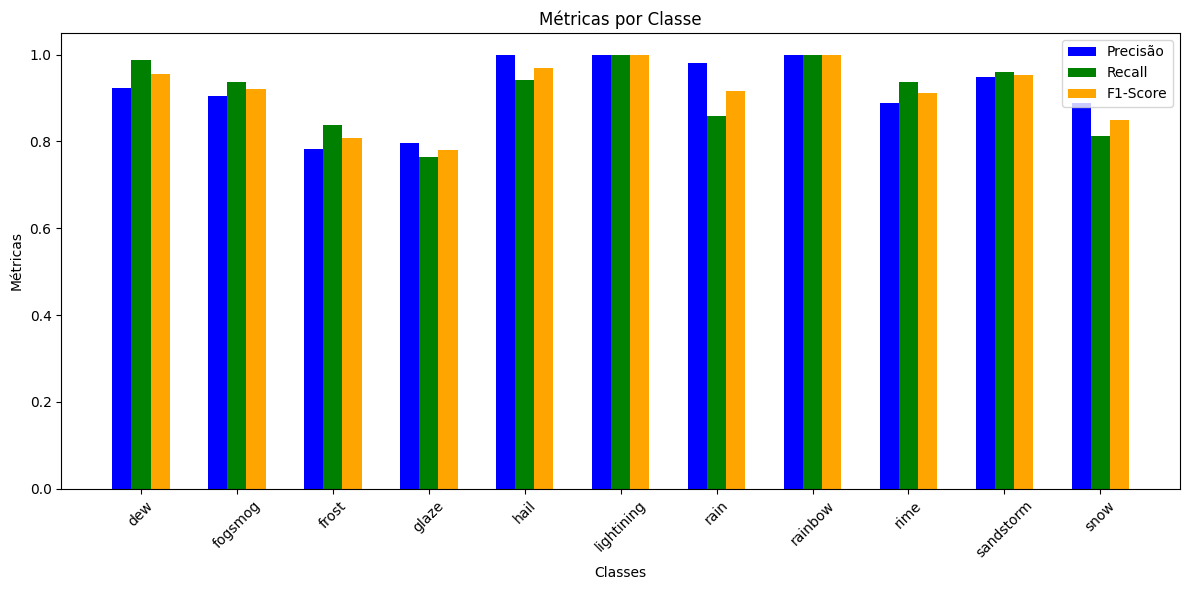

<ipython-input-17-8a1ed791e711>:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes)


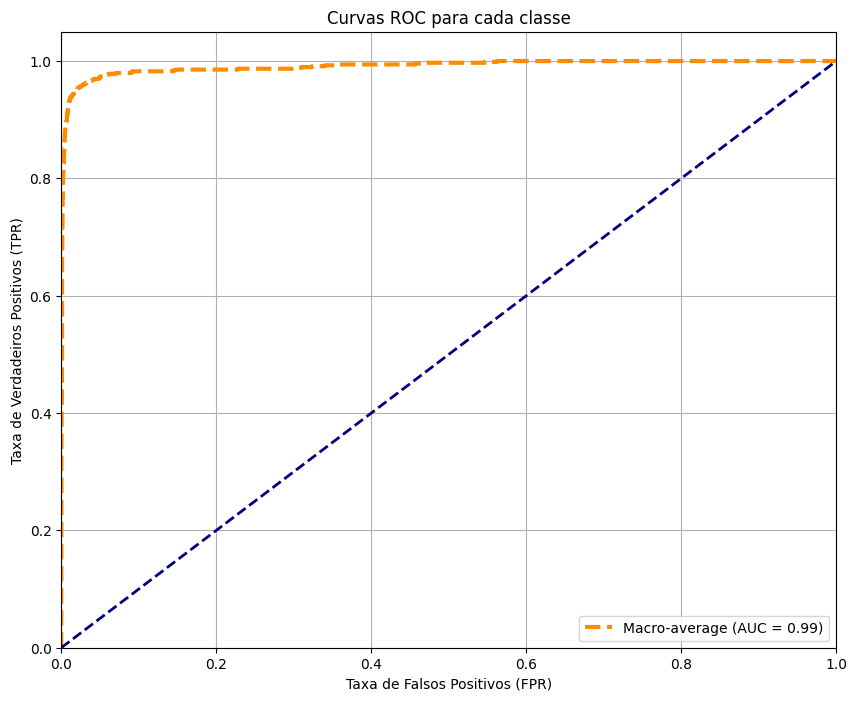

In [ ]:
# Matriz de Confusão
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list, pred_test_list,
                                              target_names=class_names, output_dict = True, #dicionário para uso pessoal
                                              digits=4,
                                              zero_division=0)
print('\nClass. report (test)')
print(class_rep_test)

print("Relatório de Classificação por Classe:")
print(metrics.classification_report(true_test_list, pred_test_list,
                                    target_names=class_names,
                                    digits=4, zero_division=0))

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\Test Acc.: {:.4f}'.format(acc_test))

# Função para mostrar imagens
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Obter um lote de dados de teste
inputs, classes = next(iter(test_dataloader))

# Fazer previsões
outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

# Plotar as imagens e suas previsões
plt.figure(figsize=(15, 10))
for i in range(min(len(inputs), 8)):  # Mostrar até 8 imagens
    ax = plt.subplot(2, 4, i + 1)
    imshow(inputs[i], title=f'Pred: {class_names[preds[i]]}\nTrue: {class_names[classes[i]]}')
plt.tight_layout()
plt.show()


#POR CLASSE
#extração de métricas
precisoes=[class_rep_test[cls]['precision'] for cls in class_names]
recalls=[class_rep_test[cls]['recall'] for cls in class_names]
f1_scores=[class_rep_test[cls]['f1-score'] for cls in class_names]

#para plotagem
x = range(len(class_names))
width = 0.2 #largura barras

plt.figure(figsize=(12, 6))
plt.bar(x, precisoes, width, label='Precisão', color='blue')
plt.bar([i + width for i in x], recalls, width, label='Recall', color='green')
plt.bar([i + 2 * width for i in x], f1_scores, width, label='F1-Score', color='orange')

#dos eixos
plt.xlabel('Classes')
plt.ylabel('Métricas')
plt.title('Métricas por Classe')
plt.xticks([i + width for i in x], class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#CURVA ROC
true_binarized = label_binarize(true_test_list, classes=list(range(num_classes)))

#variaveis para curvas e areas
fpr = dict()
tpr = dict()
roc_auc = dict()

#calcular curva roc e auc para cada classe
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], [p[i] for p in prob_test_list])
    roc_auc[i] = auc(fpr[i], tpr[i])

#calcular marcro-average roc e auc
fpr["macro"], tpr["macro"], _=roc_curve(
    true_binarized.ravel(), [p for probs in prob_test_list for p in probs]
)

roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#plotar curvas roc para cada classe
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", num_classes)

"""
for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors(i),
        lw=2,
        label=f"Classe {class_names[i]} (AUC = {roc_auc[i]:0.2f})",
    )
"""

# Adicionar curva macro-average
plt.plot(
    fpr["macro"],
    tpr["macro"],
    color="darkorange",
    linestyle="--",
    lw=3,
    label=f"Macro-average (AUC = {roc_auc['macro']:0.2f})",
)

# Configurar o gráfico
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curvas ROC para cada classe")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#Créditos

In [ ]:
https://github.com/joaofmari/awesome-computer-vision-deep-learning